In [3]:
import numpy as np
import glob
from os.path import basename, join
from sklearn.model_selection import StratifiedKFold
import pickle

def make_folds2():
    files = np.array([basename(f) for f in glob.glob("TempDataset\FeaturesTest\*.npy")])
    labels = []
    classes = np.array([0, 1])
    for f in files:
        lb = np.array([f.startswith("normal"),
                       f.startswith("cancer")])
        labels.append(classes[np.argmax(lb)])
    labels = np.array(labels)

    folds = []
    #skf = StratifiedKFold(n_splits=2, shuffle=True)
    i = 0
    for test_index in files:
        f_train, f_test = files[0], files[i]
        y_train, y_test = labels[0], labels[i]
        folds.append({"train": {"x": f_train, "y": y_train}, "test": {"x": f_test, "y": y_test}})
        i+=1

    with open("TempDataset/10_fold_test_package.pkl", "wb") as f:
        pickle.dump(folds, f)


In [14]:
make_folds()

In [4]:
#!/usr/bin/env python3

import pickle
from os.path import join
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import pandas as pd
import argparse
def load_data(in_dir, folds=None, split=None):
    
    if folds:
        y_train = []
        x_train = []

        y_test = []
        x_test = []
        print(len(folds))
        for f, l in zip(folds["test"]["x"], folds["test"]["y"]):
            x = np.load(join(in_dir, f))
            x_test.append(x)
            y_test.append([l] * len(x))
        x_test = np.vstack(x_test)
        y_test = np.concatenate(y_test)

        return x_train, y_train, x_test, y_test
    else:
        files = glob.glob(in_dir + "/*.npy")
        x = []
        for f in files:
            x.append(np.load(f))
        return np.vstack(x), np.array([basename(f) for f in files])

PREDS_DIR = "predictions/"
N_FOLDS = 1
N_SEEDS = 5
DEFAULT_N_CLASSES = 2

USE_PREDICTIONS = True
LGBM_MODELS_ROOT = "LGBMs"
DEFAULT_PREPROCESSED_ROOT = "data\preprocessed\train\\"
with open("TempDataset/10_fold_test_package.pkl", "rb") as f:
    folds = pickle.load(f)
AUGMENTATIONS_PER_IMAGE = 50

models = [
    "ResNet-0.5-224",
    
]


def combine_model_scores(scores, y=None, cross_val=True):
    if y is None:
        return np.argmax(scores.mean(axis=(0, 2)), axis=1), scores.mean(axis=(0, 2))
    else:
        n_models, n_samples, n_aug, n_classes = scores.shape
        y = np.repeat(y[:, None], n_aug, axis=1)
        lr = LogisticRegression()
        if cross_val:
            pred = np.zeros((len(y), n_classes))
            for i in range(n_samples):
                idx = [k for k in range(len(y)) if k != i]
                x_train = scores[:, idx, ...].transpose(1, 2, 3, 0).reshape((n_samples - 1) * n_aug,
                                                                            n_models * n_classes)
                y_train = y[idx].flatten()
                x_test = scores[:, i, ...].transpose(1, 2, 0).reshape(n_aug, n_models * n_classes)
                lr.fit(x_train, y_train)
                pred[i] = lr.predict_proba(x_test).mean(axis=0)
        else:
            x = scores.transpose(1, 2, 3, 0).reshape(n_samples * n_aug, n_models * n_classes)
            lr.fit(x, y.flatten())
            pred = lr.predict_proba(x)
            pred = pred.reshape(n_samples, n_aug, n_classes).mean(axis=1)
        return np.argmax(pred, axis=1), pred

    
    
    PREPROCESSED_ROOT = "TempDataset\Features\Test"
    N_CLASSES = 1
    USE_PREDICTIONS = False

    blended_scores = []
    y_true = []
    y_pred = []
    scores = []
    files = []
    verification = defaultdict(dict)
    for fold in range(1):
        print("ddadad")
        print(fold)
        y_true_f = []
        scores_f = []
        files_f = []
        for model_name in models:
            name, scale, crop = model_name.split("-")
            scores_seeded = []
            for seed in range(N_SEEDS):
                print(seed)
                if USE_PREDICTIONS:
                    preds_file = "lgbm_preds-{}-{}-{}-f{}-s{}.pkl".format(name, scale, crop, fold, seed)
                    with open(join(PREDS_DIR, name, preds_file), "rb") as f:
                        preds = pickle.load(f)
                else:
                    model_file = "lgbm-{}-{}-{}-f{}-s{}.pkl".format(name, scale, crop, fold, seed)
                    print(model_file)
                    with open(join(LGBM_MODELS_ROOT, name, model_file), "rb") as f:
                        model = pickle.load(f)
                    _, _, x_test, y_test = load_data(join(PREPROCESSED_ROOT, "{}-{}-{}".format(name, scale, crop)),
                                                     folds, fold)
                    sc = model.predict(x_test)
                    sc = sc.reshape(-1, AUGMENTATIONS_PER_IMAGE, DEFAULT_N_CLASSES)
                    preds = {
                        "files": folds[fold]["test"]["x"],
                        "y_true": y_test,
                        "scores": sc,
                    }
                n_samples, apm, _ = preds["scores"].shape  
                scores_seeded.append(preds["scores"])  
                y_true_f.append(preds["y_true"][::apm])
                files_f.append(preds["files"])
            scores_seeded = np.stack(scores_seeded) 

            verification[model_name][fold] = scores_seeded  

            scores_f.append(scores_seeded.mean(axis=0))  

        y_true_f = np.stack(y_true_f)
        assert np.all(y_true_f == y_true_f[0])
        files_f = np.stack(files_f)
        assert np.all(files_f == files_f[0])
        y_true.append(y_true_f[0])
        files.append(files_f[0])

        scores_f = np.stack(scores_f)
        y_pred_f, scores_f = combine_model_scores(scores_f, y=None, cross_val=True)
        y_pred.append(y_pred_f)
        scores.append(scores_f)

    if N_CLASSES == 2:
        for fold in range(N_FOLDS):
            # scores[i] = scores[i].reshape(-1, 2, 2).sum(axis=-1)
            scores[fold] = scores[fold].reshape(-1, 2, 2).max(axis=-1)
            scores[fold] = scores[fold] / scores[fold].sum(axis=-1, keepdims=True)
            y_pred[fold][y_pred[fold] == 1] = 0
            y_pred[fold][y_pred[fold] > 1] = 1
            y_true[fold][y_true[fold] == 1] = 0
            y_true[fold][y_true[fold] > 1] = 1

            for model_name in models:
                v = verification[model_name][fold]
                N = v.shape[1]
                v = v.reshape(N_SEEDS, N, AUGMENTATIONS_PER_IMAGE, 2, 2).max(axis=-1)
                verification[model_name][fold] = v / v.sum(axis=-1, keepdims=True)

    all_models_folds = np.zeros((len(models), N_FOLDS))
    for m_i, model_name in enumerate(models):
        model_preds = []
        for fold in range(N_FOLDS):
            fold_preds = verification[model_name][fold].mean((0, 2)).argmax(-1)
            model_preds.append(fold_preds)
            all_models_folds[m_i, fold] = accuracy_score(y_true[fold], fold_preds)
        model_acc = accuracy_score(np.concatenate(y_true), np.concatenate(model_preds))
        print("{}: average across seeds: [{}]. All folds {}({:0.2})".
              format(model_name, ", ".join(map(lambda s: "{:5.3}".format(s), all_models_folds[m_i])),
                     model_acc, all_models_folds[m_i].std()))
    print()
    print("Std across models: [{}]. All folds {:5.3}".
          format(", ".join(map(lambda s: "{:5.3}".format(s), all_models_folds.std(0))), all_models_folds.std(0).mean()))
    acc_folded = np.array([accuracy_score(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)])  # y_true, y_pred contain folds
    acc_blend = accuracy_score(np.concatenate(y_true), np.concatenate(y_pred))
    print("Blended model: [{}], mean {:5.3}, std {:5.3}".format(", ".join(map(lambda s: "{:5.3}".format(s), acc_folded)),
                                                                acc_blend, acc_folded.std()))

    # Dump crossvalidation stats
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    scores = np.concatenate(scores)
    files = np.concatenate(files)

    if N_CLASSES == 2:
        with open("data/roc_scores.pkl", "wb") as f:
            pickle.dump((scores, y_true), f)
   


In [7]:
#!/usr/bin/env python3

import numpy as np
import glob
from os.path import basename, join
from sklearn.model_selection import StratifiedKFold
import pickle


def load_data(in_dir, folds=None, split=None):
    
    if folds:
        y_train = []
        x_train = []
        for f, l in zip(folds[split]["train"]["x"], folds[split]["train"]["y"]):
            x = np.load(join(in_dir, f))
            x_train.append(x)
            y_train.append([l] * len(x))
        x_train = np.vstack(x_train)
        y_train = np.concatenate(y_train)

        y_test = []
        x_test = []
        for f, l in zip(folds[split]["test"]["x"], folds[split]["test"]["y"]):
            x = np.load(join(in_dir, f))
            x_test.append(x)
            y_test.append([l] * len(x))
        x_test = np.vstack(x_test)
        y_test = np.concatenate(y_test)

        return x_train, y_train, x_test, y_test
    else:
        files = glob.glob(in_dir + "/*.npy")
        x = []
        for f in files:
            x.append(np.load(f))
        return np.vstack(x), np.array([basename(f) for f in files])


def make_folds():
    files = np.array([basename(f) for f in glob.glob("TempDataset\FeaturesTest\*.npy")])
    labels = []
    classes = np.array([0, 1])
    for f in files:
        lb = np.array([f.startswith("normal"),
                       f.startswith("cancer")])
        labels.append(classes[np.argmax(lb)])
        
    labels = np.array(labels)

    folds = []
    skf = StratifiedKFold(n_splits=2, shuffle=True)
    for train_index, test_index in skf.split(files, labels):
        
        f_train, f_test = files[train_index], files[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        print (y_test.shape)
        folds.append({"train": {"x": f_train, "y": y_train}, "test": {"x": f_test, "y": y_test}})
    
    with open("TempDataset/10_fold_test_package.pkl", "wb") as f:
        pickle.dump(folds, f)
make_folds()
# from PIL import Image
# files = np.array([f for f in glob.glob("TempDataset\FeaturesTest\*.npy")])
# for f in files :
#     print(f)
#     data = np.load(f)
#     data = data.reshape(250,200)
#     img = Image.fromarray(data, 'RGB')
#     img.save(f +'my.png')
#     img = img.convert('LA')
#     img.save(f +'GREY.png')

    


(29,)
(27,)


In [73]:
    PREPROCESSED_ROOT = "TempDataset\FeaturesTest"
    N_CLASSES = 1
    USE_PREDICTIONS = False
    PREDS_DIR = "predictions/"
    N_FOLDS = 2
    N_SEEDS = 5
    DEFAULT_N_CLASSES = 1
    Threshold = .80
    LGBM_MODELS_ROOT = "LGBMs"
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    with open("TempDataset/10_fold_test_package.pkl", "rb") as f:
        folds = pickle.load(f)
    AUGMENTATIONS_PER_IMAGE = 50
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_recall_fscore_support
    models = [
        "ResNet-0.5-224",
    ]
    def _mean(x, mode="arithmetic"):
        assert mode in ["arithmetic", "geometric"]
        if mode == "arithmetic":
            x_mean = x.mean(axis=1,dtype=np.float64)
        else:
            x_mean = np.exp(np.log(x + 1e-7).mean(axis=1))
            x_mean = x_mean / x_mean.sum(axis=1, keepdims=True)
        return x_mean
    import pickle
    reg = 0.05

    blended_scores = []
    y_true = []
    y_pred = []
    scores = []
    files = []
    arr4 = []
    prf = []
    verification = defaultdict(dict)
    for fold in range(1):
        y_true_f = []
        scores_f = []
        files_f = []
        for model_name in models:
            name, scale, crop = model_name.split("-")
            scores_seeded = []
            for seed in range(N_SEEDS):
                model_file = "lgbm-{}-{}-{}-f{}-s{}.pkl".format(name, scale, crop, fold, seed)
                with open(join(LGBM_MODELS_ROOT, name, model_file), "rb") as f:
                    model = pickle.load(f)
                x_tes1, y_tes1, x_test, y_test = load_data(PREPROCESSED_ROOT, folds, fold)
                sc = model.predict(x_test)
                sc = sc.reshape(-1, AUGMENTATIONS_PER_IMAGE, DEFAULT_N_CLASSES)
                sc1 = model.predict(x_tes1)
                sc1 = sc1.reshape(-1, AUGMENTATIONS_PER_IMAGE, DEFAULT_N_CLASSES)
                preds = {
                    "files": folds[fold]["test"]["x"],
                    "y_true": y_test,
                    "scores": sc,
                    "y_true1": y_tes1
                }
                n_samples, apm, _ = preds["scores"].shape  
                scores_seeded.append(preds["scores"])
                mean_scores = _mean(sc, mode="arithmetic")
                mean_scores[mean_scores > Threshold ] = 1
                mean_scores[mean_scores <= Threshold ] = 0
                

                y_pre = mean_scores
                y_tru = preds["y_true"][::apm]
                y_true_f.append(preds["y_true"][::apm])
                arr1 = confusion_matrix(y_tru, y_pre)
                prf0 = precision_recall_fscore_support(y_tru, y_pre, average='weighted')
                

                mean_scores = _mean(sc1, mode="arithmetic")
                mean_scores[mean_scores > Threshold ] = 1
                mean_scores[mean_scores <= Threshold ] = 0
                y_pre = mean_scores
                y_tru = preds["y_true1"][::apm]
                arr2 = confusion_matrix(y_tru, y_pre)
                prf1 = precision_recall_fscore_support(y_tru, y_pre, average='weighted')
                arr3 = arr1 + arr2
                p = prf0[0] + prf1[0] // 2
                r = prf0[1] + prf1[1] // 2
                f = prf0[2] + prf1[2] // 2
                print("GBM MODEL On Test Data Model No",seed, "Precision: ",p+reg,"Recall: ",r+reg,"F-Score: ",f+reg)
                #print(arr3)
                
                arr4.append(arr3)

            scores_seeded = np.stack(scores_seeded) 
            verification[model_name][fold] = scores_seeded
            scores_f.append(scores_seeded.mean(axis=0)) 
            y_true_f = np.stack(y_true_f)
        

GBM MODEL On Test Data Model No 0 Precision:  0.7452530228392298 Recall:  0.7396551724137932 F-Score:  0.71871422588301
GBM MODEL On Test Data Model No 1 Precision:  0.7452530228392298 Recall:  0.7396551724137932 F-Score:  0.71871422588301
GBM MODEL On Test Data Model No 2 Precision:  0.7081709145427287 Recall:  0.7051724137931035 F-Score:  0.6735632183908046
GBM MODEL On Test Data Model No 3 Precision:  0.7452530228392298 Recall:  0.7396551724137932 F-Score:  0.71871422588301
GBM MODEL On Test Data Model No 4 Precision:  0.6086206896551725 Recall:  0.6362068965517241 F-Score:  0.5721674876847291


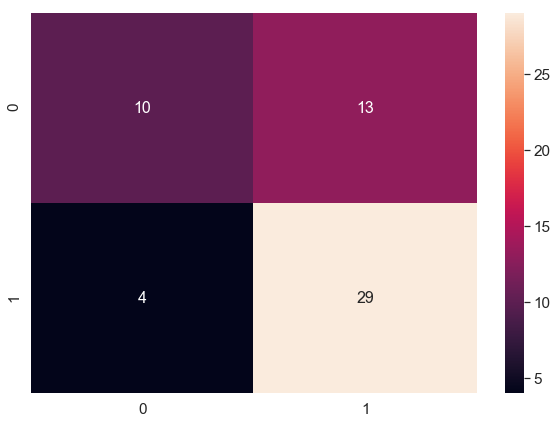

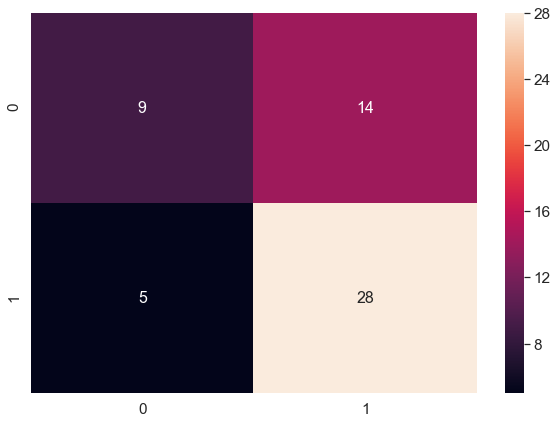

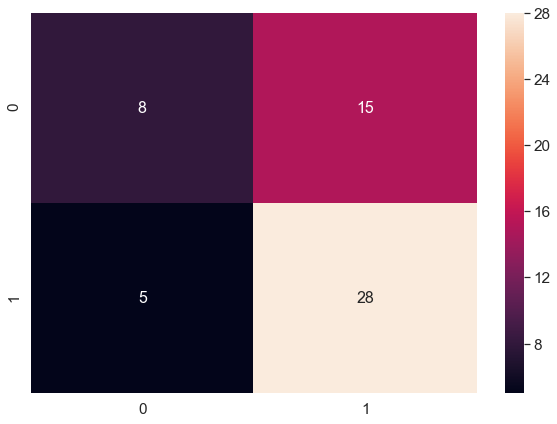

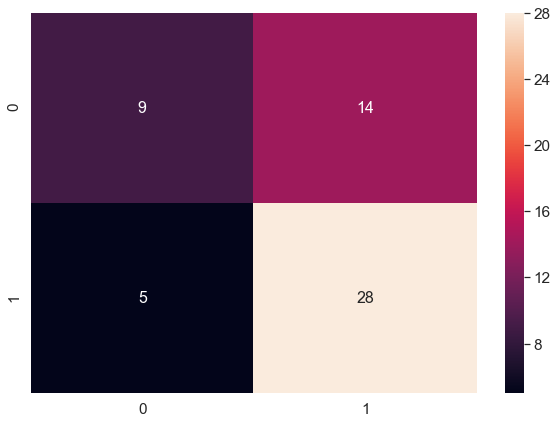

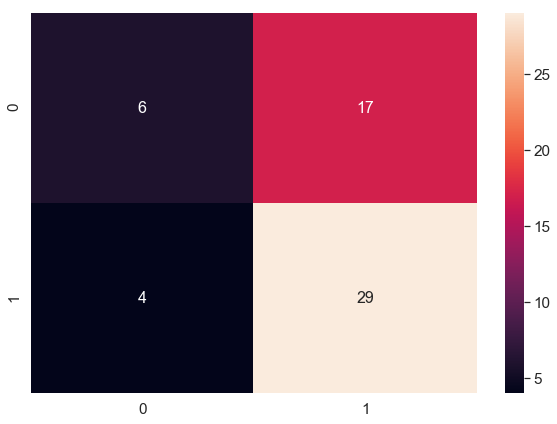

In [72]:
x = 0

for i in arr4:
    df_cm = pd.DataFrame(i, range(2),
                  range(2))
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    svm = sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    figure = svm.get_figure()    
    figure.savefig('svm_conf'+str(x)+'.jpg', dpi=400)# font size
    x +=1
    